In [13]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [2]:
column_names = ['unique_key','created_date','closed_date','agency','agency_name','complaint_type','descriptor','location_type',
                'incident_zip','incident_address','street_name','cross_street_1','cross_street_2','intersection_street_1',
                'intersection_street_2','address_type','city','landmark','facility_type','status','due_date','resolution_description',
                'resolution_action_updated_date','community_board','bbl','borough','x_coordinate_state_plane','y_coordinate_state_plane',
                'open_data_channel_type','park_facility_name','park_borough','vehicle_type','taxi_company_borough','taxi_pick_up_location',
                'bridge_highway_name','bridge_highway_direction','road_ramp','bridge_highway_segment','latitude','longitude','location']

In [3]:
def load_data(usecols):
    column_names_use = [column_names[ind] for ind in usecols]
    dtypes = {k: 'object' for k in column_names_use}

    df = dd.read_csv('nyc_311_2020.csv', header=None, names=column_names_use, dtype=dtypes, usecols=usecols)
    
    return df

def convert_datetime(df, colname):
    date_format = '%m/%d/%Y %I:%M:%S %p'
    df[colname] = dd.to_datetime(df[colname], format=date_format, errors='coerce')
    
    return df

In [4]:
def filter_data_by_date(df, datecol, start_date, end_date):
    start_date = pd.to_datetime(start_date, format="%Y-%m-%d")
    end_date = pd.to_datetime(end_date, format="%Y-%m-%d")
    
    df_filtered = df[(df[datecol] >= start_date) & (df[datecol] <= end_date)]
    
    return df_filtered

---------------------------

# V1: The mayor wants to know if noise issues tend to stem from different causes across the year.

## V2: Do the noise issue stem from different causes across the four quarters of 2020?

Refining the 'across the year' part to make it quantifiable. Also fixing the year to 2020.

In [29]:
data = load_data([1, 5, 6])
all_complaint_types = data['complaint_type'].value_counts().compute().to_dict()
print(all_complaint_types)

In [6]:
data_noise = data[data['complaint_type'].str.contains('Noise')]
all_complaint_causes = data_noise['descriptor'].value_counts().compute().to_dict()
print(all_complaint_causes)

{'Loud Music/Party': 404121, 'Banging/Pounding': 67761, 'Car/Truck Music': 45342, 'Loud Talking': 39837, 'Noise: Construction Before/After Hours (NM1)': 12044, 'Car/Truck Horn': 11251, 'Engine Idling': 8339, 'Noise: Construction Equipment (NC1)': 5696, 'Other': 4695, 'Loud Television': 4529, 'Noise, Barking Dog (NR5)': 3388, 'Noise: air condition/ventilation equipment (NV1)': 2663, 'Noise: Alarms (NR3)': 2550, 'Noise: Jack Hammering (NC2)': 2096, 'Noise, Ice Cream Truck (NR4)': 1958, 'Noise: Private Carting Noise (NQ1)': 770, 'NYPD': 760, 'Noise: lawn care equipment (NCL)': 352, 'Noise: Boat(Engine,Music,Etc) (NR10)': 270, 'Noise, Other Animals (NR6)': 177, 'Noise: Manufacturing Noise (NK1)': 166, 'News Gathering': 160, 'Noise:  lawn care equipment (NCL)': 149, 'Noise: Other Noise Sources (Use Comments) (NZZ)': 8, '21 Collection Truck Noise': 3, 'Noise: Loud Music From Siebel System - For Dep Internal Use Only (NP21)': 1, 'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)': 1, 'Nois

In [7]:
data_noise = convert_datetime(data_noise, 'created_date')

In [8]:
data_noise.head()

,created_date,complaint_type,descriptor
6,2018-11-20 01:45:00,Noise,Noise: Construction Before/After Hours (NM1)
44,2018-11-21 17:01:54,Noise - Street/Sidewalk,Loud Music/Party
49,2018-11-21 23:55:09,Noise - Residential,Banging/Pounding
90,2018-11-23 00:56:03,Noise - Residential,Loud Music/Party
109,2018-11-23 17:01:10,Noise - Commercial,Loud Music/Party


In [9]:
quarters = [('2020-01-01', '2020-03-31'), ('2020-04-01', '2020-06-30'), 
            ('2020-07-01', '2020-09-30'), ('2020-10-01', '2020-12-31')]

In [20]:
quarters_with_causes = {}
quarters_with_num_complaints = {}
for (start_date, end_date) in quarters:
    data_noise_filtered = filter_data_by_date(data_noise, 'created_date', start_date, end_date)
    all_complaint_causes = data_noise_filtered['descriptor'].value_counts().compute().to_dict()
    
    quarters_with_causes[(start_date, end_date)] = all_complaint_causes
    quarters_with_num_complaints[(start_date, end_date)] = len(data_noise_filtered)
    print(all_complaint_causes)

{'Loud Music/Party': 44480, 'Banging/Pounding': 21606, 'Loud Talking': 8132, 'Noise: Construction Before/After Hours (NM1)': 5261, 'Car/Truck Music': 3819, 'Car/Truck Horn': 2402, 'Engine Idling': 2029, 'Noise: Construction Equipment (NC1)': 1860, 'Other': 1704, 'Loud Television': 1628, 'Noise, Barking Dog (NR5)': 1296, 'Noise: air condition/ventilation equipment (NV1)': 860, 'Noise: Jack Hammering (NC2)': 653, 'Noise: Alarms (NR3)': 602, 'Noise: Private Carting Noise (NQ1)': 388, 'Noise, Ice Cream Truck (NR4)': 225, 'Noise: lawn care equipment (NCL)': 65, 'Noise, Other Animals (NR6)': 51, 'NYPD': 45, 'Noise: Manufacturing Noise (NK1)': 44, 'Noise: Boat(Engine,Music,Etc) (NR10)': 23, 'News Gathering': 17, 'Noise: Other Noise Sources (Use Comments) (NZZ)': 6, 'Noise: Loud Music From Siebel System - For Dep Internal Use Only (NP21)': 1}
{'Loud Music/Party': 142138, 'Banging/Pounding': 26593, 'Loud Talking': 17596, 'Car/Truck Music': 15249, 'Car/Truck Horn': 3814, 'Engine Idling': 3300, '

## V3: Do the top 5 causes of noise change across the four quarters of 2020?

To focus only on the main causes of noise in every quarter

In [21]:
for (start_date, end_date) in quarters:
    all_complaint_causes = quarters_with_causes[(start_date, end_date)]
    
    filtered_complaints_causes = {}
    for idx, k in enumerate(all_complaint_causes):
        if idx == 5: break
        filtered_complaints_causes[k] = all_complaint_causes[k]
    
    print(filtered_complaints_causes)

{'Loud Music/Party': 44480, 'Banging/Pounding': 21606, 'Loud Talking': 8132, 'Noise: Construction Before/After Hours (NM1)': 5261, 'Car/Truck Music': 3819}
{'Loud Music/Party': 142138, 'Banging/Pounding': 26593, 'Loud Talking': 17596, 'Car/Truck Music': 15249, 'Car/Truck Horn': 3814}
{'Loud Music/Party': 213743, 'Car/Truck Music': 25928, 'Banging/Pounding': 18198, 'Loud Talking': 13528, 'Car/Truck Horn': 4862}
{}


## V4: What are the percentages of noise complaints due to the top 5 causes across the four quarters of 2020?

We need to quantify the comparison between different causes across different quarters. Since we are interested in whether the causes of noise change or not, I made a decision to use percentages and get rid of the actual numbers.

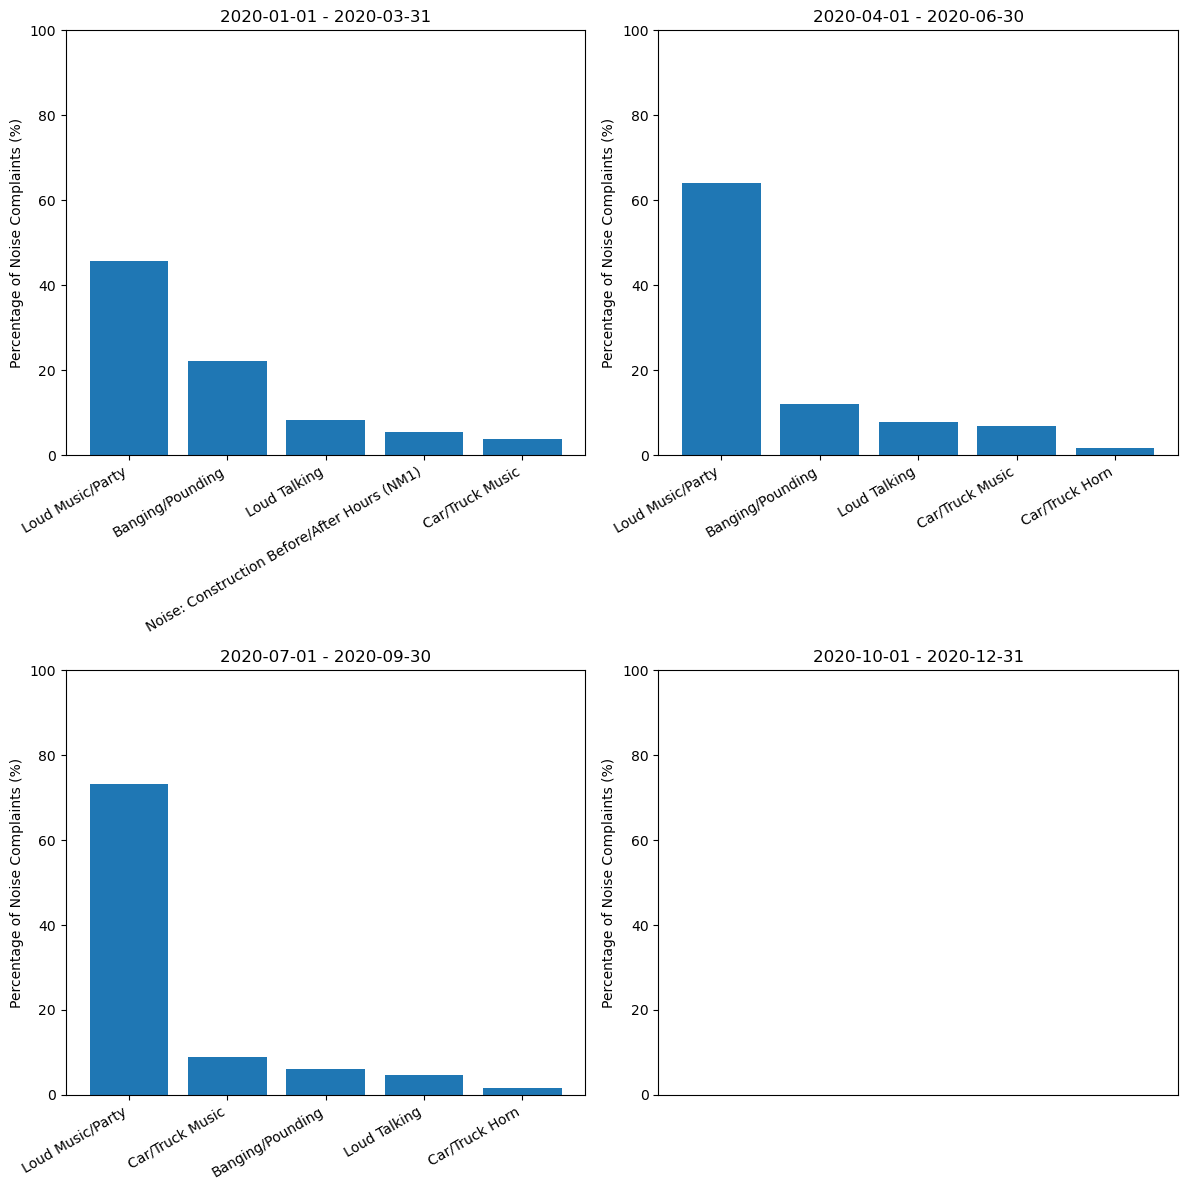

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for qind, (start_date, end_date) in enumerate(quarters):
    num_complaints = quarters_with_num_complaints[(start_date, end_date)]
    all_complaint_causes = quarters_with_causes[(start_date, end_date)]
    
    filtered_complaints_causes = {}
    for idx, k in enumerate(all_complaint_causes):
        if idx == 5: break
        filtered_complaints_causes[k] = (all_complaint_causes[k]/num_complaints)*100
    
    ax[qind//2, qind%2].bar(range(len(filtered_complaints_causes)), list(filtered_complaints_causes.values()), align='center')
    ax[qind//2, qind%2].set_xticks(range(len(filtered_complaints_causes)), list(filtered_complaints_causes.keys()))
    
    ax[qind//2, qind%2].set_title('%s - %s' % (start_date, end_date))
    ax[qind//2, qind%2].set_ylabel('Percentage of Noise Complaints (%)')
    ax[qind//2, qind%2].set_ylim(0, 100)
    
    plt.setp(ax[qind//2, qind%2].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()

--------------------

# V1: Where in the city rats and mice are most likely to create sanitation issues?

## V2: Where in the city rats and mice caused most sanitation issues in 2020?

Rephrasing the question to focus on the data and also restricting to the data from 2020.

In [39]:
data = load_data([1, 5, 6, 7])
all_complaint_types = data['complaint_type'].value_counts().compute().to_dict()
print(all_complaint_types)

{'Noise - Residential': 309103, 'Noise - Street/Sidewalk': 171096, 'Illegal Parking': 134894, 'HEAT/HOT WATER': 89610, 'Non-Emergency Police Matter': 80527, 'Blocked Driveway': 79273, 'Damaged Tree': 70263, 'Noise - Vehicle': 62100, 'Street Light Condition': 52007, 'Illegal Fireworks': 48671, 'Street Condition': 42759, 'Water System': 40835, 'UNSANITARY CONDITION': 38532, 'Noise': 32290, 'Noise - Commercial': 32158, 'Consumer Complaint': 31102, 'General Construction/Plumbing': 30100, 'NonCompliance with Phased Reopening': 29788, 'Missed Collection (All Materials)': 29731, 'Sidewalk Condition': 24870, 'Abandoned Vehicle': 24750, 'Traffic Signal Condition': 24577, 'PLUMBING': 22061, 'Derelict Vehicles': 22012, 'Dirty Conditions': 21607, 'Rodent': 21557, 'Homeless Person Assistance': 19997, 'Sewer': 19882, 'New Tree Request': 17563, 'PAINT/PLASTER': 17083, 'Building/Use': 16787, 'Overgrown Tree/Branches': 16239, 'Maintenance or Facility': 14860, 'Graffiti': 14611, 'DOOR/WINDOW': 13655, 'W

In [38]:
data_rodent = data[data['complaint_type']=='Rodent']
all_complaint_locations = data_rodent['location_type'].value_counts().compute().to_dict()
print(all_complaint_locations)

{'3+ Family Apt. Building': 9169, '1-2 Family Dwelling': 5179, 'Other (Explain Below)': 2243, 'Commercial Building': 1385, '3+ Family Mixed Use Building': 1030, 'Construction Site': 493, '1-2 Family Mixed Use Building': 413, 'Vacant Lot': 301, 'Parking Lot/Garage': 258, 'Vacant Building': 240, 'Catch Basin/Sewer': 199, '3+ Family Apartment Building': 198, 'Street Area': 99, 'Residential Building': 67, 'Government Building': 49, 'Public Garden': 27, 'Residence': 26, 'Apartment': 24, 'School/Pre-School': 23, 'Single Room Occupancy (SRO)': 22, 'Other': 21, 'Day Care/Nursery': 20, 'Hospital': 16, 'Public Stairs': 15, 'Restaurant': 9, 'Office Building': 7, 'Building (Non-Residential)': 6, 'Residential Property': 3, 'Restaurant/Bar/Deli/Bakery': 3, '1-3 Family Mixed Use Building': 3, 'Cafeteria - Public School': 2, 'Store': 2, 'Private House': 1, '1-3 Family Dwelling': 1, 'Retail Store': 1}


## V3: In which types of buildings rats and mice caused most sanitation issues in 2020?

Specify that we are looking into the location type

In [41]:
location_category_mapping = {
    '3+ Family Apt. Building': 'residential_areas',
    '1-2 Family Dwelling': 'residential_areas',
    '3+ Family Mixed Use Building': 'residential_areas',
    '1-2 Family Mixed Use Building': 'residential_areas',
    'Vacant Building': 'residential_areas',
    '3+ Family Apartment Building': 'residential_areas',
    'Residential Building': 'residential_areas',
    'Residence': 'residential_areas',
    'Apartment': 'residential_areas',
    'Single Room Occupancy (SRO)': 'residential_areas',
    'Residential Property': 'residential_areas',
    '1-3 Family Mixed Use Building': 'residential_areas',
    'Private House': 'residential_areas',
    '1-3 Family Dwelling': 'residential_areas',
    
    'Commercial Building': 'commercial_areas',
    'Parking Lot/Garage': 'commercial_areas',
    'Vacant Lot': 'commercial_areas',
    'Restaurant': 'commercial_areas',
    'Restaurant/Bar/Deli/Bakery': 'commercial_areas',
    'Retail Store': 'commercial_areas',
    'Store': 'commercial_areas',
    
    'Street Area': 'public_spaces',
    'Public Garden': 'public_spaces',
    'Public Stairs': 'public_spaces',
    'Catch Basin/Sewer': 'public_spaces',
    
    'Government Building': 'government_and_institutional_buildings',
    'Hospital': 'government_and_institutional_buildings',
    'School/Pre-School': 'government_and_institutional_buildings',
    'Day Care/Nursery': 'government_and_institutional_buildings',
    'Cafeteria - Public School': 'government_and_institutional_buildings',
    'Office Building': 'government_and_institutional_buildings',
    
    'Construction Site': 'construction',
    
    'Other (Explain Below)': 'other',
    'Other': 'other',
    'Building (Non-Residential)': 'other'
}

In [42]:
data_rodent['location_type'] = data_rodent['location_type'].map(location_category_mapping)

In [44]:
all_complaint_locations = data_rodent['location_type'].value_counts().compute().to_dict()
print(all_complaint_locations)

{'residential_areas': 16376, 'other': 2270, 'commercial_areas': 1959, 'construction': 493, 'public_spaces': 340, 'government_and_institutional_buildings': 117}


## V4: In which category of building, as defined above, most rodent complaints were lodged in 2020?

Specify the use of broader categories defined above, and also map the quesiton to the exact quantifiable item, i.e., the number of rodent complaints.

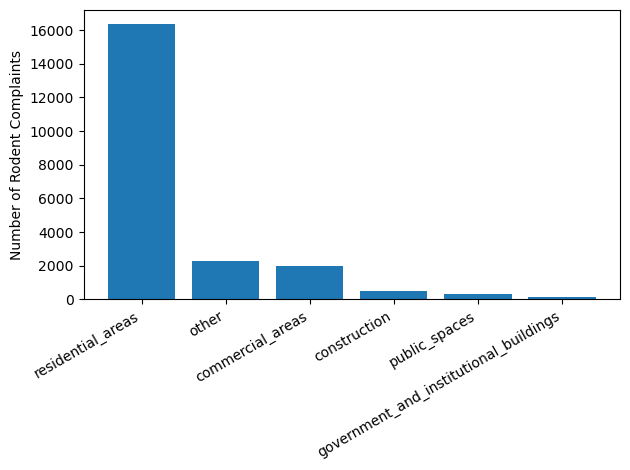

In [47]:
all_complaint_locations = data_rodent['location_type'].value_counts().compute().to_dict()

plt.bar(range(len(all_complaint_locations)), list(all_complaint_locations.values()), align='center')
plt.xticks(range(len(all_complaint_locations)), list(all_complaint_locations.keys()))

plt.ylabel('Number of Rodent Complaints')

ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()